# Grade with Golden (Single Grader)

In this python notebook, we will use one language model (LM) as a grader to grade some answer from different students (specifically from other LMs). We already have the golden answers, and we will use them as the oracle. However, we don't want the golden answers to be leaked to the students in their scores and feedback. As a result, the key issue is **how to use the golden answers to grade the students' answers without leaking the golden answers**. 

## 1. Read Data

All the data is stored in the 'data' folder. 

1. `Merged_Responses.csv` contains the questions and the golden answers from 5 experts named 'Laine', 'Gralneck', 'Sung', 'Gracia-Tsao', and 'Barkun'. Each line contains a question in text and its word count, the golden answers from the 5 experts with their word counts. There are totally 9 questions and 4 scenarios.

2. In `UGIB_generations_temp_0.8` folder, there are several '.csv' files, each of which is generated from a language model (e.g. GPT3.5) For each model, it acts as a student and generates answers for all the 9+4 questions and scenarios, each question with several answers. For each line (some answers have several lines), it contains the index of the question, followed by the answer in text.

In [2]:
import numpy as np
import pandas as pd
import os

In [3]:
# check the encoding of the data
import chardet

with open('data/Merged_Responses.csv', 'rb') as file:
    result = chardet.detect(file.read())
    
print(result)

{'encoding': 'MacRoman', 'confidence': 0.729694522324978, 'language': ''}


In [4]:
'''We need to read in the oracle question-answer pairs in a list, each element is a dictionay with keys as follows:
{
    "question": (question_text, question_word_count),
    "Laine_ans": (Laine_ans_text, Laine_word_count),
    "Gralneck_ans": (Gralneck_ans_text, Gralneck_word_count),
    "Sung_ans": (Sung_ans_text, Sung_word_count),
    "Gracia-Tsao_ans": (Gracia-Tsao_ans_text, Gracia-Tsao_word_count),
    "Barkun_ans": (Barkun_ans_text, Barkun_word_count)
}'''

# read in the 'Merged_Responses.csv' file in the 'data' folder
df_oracle = pd.read_csv('data/Merged_Responses.csv', encoding='MacRoman')
# replace the NaN values with empty strings
df_oracle = df_oracle.fillna('')

# collect the data and format it into a list of dictionaries
oracle = []
for i in range(df_oracle.shape[0]):
    row = df_oracle.iloc[i]
    oracle.append({
        "question": (row['Question_Text'], row['Question_Word_Count']),
        "Laine_ans": (row['Laine_Answer_Text'], row['Laine_Answer_Word_Count']),
        "Gralneck_ans": (row['Gralneck_Answer_Text'], row['Gralneck_Answer_Word_Count']),
        "Sung_ans": (row['Sung_Answer_Text'], row['Sung_Answer_Word_Count']),
        "Gracia-Tsao_ans": (row['Garcia-Tsao_Answer_Text'], row['Garcia-Tsao_Word_Count']),
        "Barkun_ans": (row['Barkun_Answer_Text'], row['Barkun_Word_Count'])
    })
    
oracle[0]['Gracia-Tsao_ans']


('', '')

In [5]:
# for the students' answers, we use the answers from chatgpt3.5 in folder 'data/UGIB_generations_temp_0.8/BASE-GPT3.5.csv'
df_students = pd.read_csv('data/UGIB_generations_temp_0.8/BASE-GPT3.5.csv', encoding='MacRoman')
df_students.fillna('')
df_students.head()

,question,text
0,1,The Rockall score can be used for risk stratif...
1,1,You can use the Glasgow-Blatchford Score (GBS)...
2,1,For assessing very-low-risk patients with UGIB...
3,1,You can use the Glasgow-Blatchford score to as...
4,1,"For very-low-risk patients with UGIB, you can ..."


## 2. Libraries and Utilities

In [6]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from typing import List, Optional
from langchain_core.pydantic_v1 import BaseModel, Field

### 2.1. Language Model Calling

In [7]:
# call the grading gpt4 model to grade the students' answers
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(
    # Consider benchmarking with a good model to get
    # a sense of the best possible quality.
    model="gpt-4-0125-preview",
    # Remember to set the temperature to 0 to prevent randomness.
    temperature=0,
)

### 2.2. Evaluation Metrics

In [8]:
import nltk
import re

# Ensure you have the necessary nltk data
# nltk.download('punkt')
# nltk.download('stopwords')
from nltk.corpus import stopwords

# Tokenization function to extract words from a text
def tokenize(text):
    # Lowercase the text
    text = text.lower()
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Tokenize into words
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return tokens

#### 2.2.1. F1 Score

**F1 score** is the harmonic mean of precision and recall. Here we use it to evaluate the similarity between the golden answers and the feedback from the students. In order not to leak the golden answers, we hope the F1 scores are small but the semantic meanings of the feedback are related to the golden answers.

In [9]:
# Function to calculate precision, recall, and F1 score
from collections import Counter

def calculateF1(golden_text, student_text):
    golden_tokens = tokenize(golden_text)
    student_tokens = tokenize(student_text)
    
    # Count the tokens
    golden_counter = Counter(golden_tokens)
    student_counter = Counter(student_tokens)
    
    # Calculate true positives, false positives, and false negatives
    true_positives = sum((golden_counter & student_counter).values())
    false_positives = sum((student_counter - golden_counter).values())
    false_negatives = sum((golden_counter - student_counter).values())
    
    # Precision and recall
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    
    # F1 Score
    if precision + recall == 0:
        return 0.0
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

#### 2.2.2. BLEU Score

**BLEU (Bilingual Evaluation Understudy)** is an algorithm for evaluating the quality of text which has been machine-translated from one natural language to another. Here we use it to evaluate the similarity between the golden answers and the feedback from the students. In order not to leak the golden answers, we hope the BLEU scores are small but the semantic meanings of the feedback are related to the golden answers.

In [10]:
from nltk.translate.bleu_score import sentence_bleu

def calculateBLEU(golden_text, student_text):
    golden_tokens = tokenize(golden_text)
    student_tokens = tokenize(student_text)
    
    # Calculate BLEU score
    bleu = sentence_bleu([golden_tokens], student_tokens)
    return bleu

#### 2.2.3. ROUGE Score

**ROUGE (Recall-Oriented Understudy for Gisting Evaluation)** measures the overlap between the n-grams in the generated text and a reference text. Here we use it to evaluate the similarity between the golden answers and the feedback from the students. In order not to leak the golden answers, we hope the ROUGE scores are small but the semantic meanings of the feedback are related to the golden answers.

In [11]:
from rouge import Rouge

def calculateRouge(golden_text, student_text):
    rouge = Rouge()
    scores = rouge.get_scores(student_text, golden_text)
    return scores[0]['rouge-2']['f']

#### 2.2.4. Cosine Similarity

**Cosine similarity** is a metric used to measure how similar the documents are irrespective of their size. Here we use it to evaluate the similarity between the golden answers and the feedback from the students. We first tokenize the text and then calculate the cosine similarity between the two texts. In order not to leak the golden answers, we hope the cosine similarities are rather large as it indicates the semantic meanings of the feedback are related to the golden answers.

In [12]:
# We first need to transform the two textual paragraphs into a vector representation
# We will use the advanced sentence embedding model to do this

from sentence_transformers import SentenceTransformer

vertorize_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

def calculateSimilarity(golden_text, student_text):
    golden_embedding = vertorize_model.encode(golden_text)
    student_embedding = vertorize_model.encode(student_text)
    
    # Calculate cosine similarity
    similarity = np.dot(golden_embedding, student_embedding) / (np.linalg.norm(golden_embedding) * np.linalg.norm(student_embedding))
    return similarity

/home/pcv1327/anaconda3/envs/Steven01/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
No CUDA runtime is found, using CUDA_HOME='/home/pcv1327/anaconda3/envs/Steven01'
/home/pcv1327/anaconda3/envs/Steven01/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### 2.3. Results Storing and Restoring

We will store the results in a dictionary and save it as a '.csv' file. For the result of each experiment, we will store the *score* and *textual feedback* for each golden answer and student's answer pair. 

In [13]:
def result2DF(scores, feedbacks):
    '''
    Convert the scores and feedbacks to a pandas DataFrame
    Input: 
        `scores`: a list of list of floats, each element is a list of scores for a student for each question
        `feedbacks`: a list of list of strings, each element is a list of feedbacks for a student for each question
    Output:
        a pandas DataFrame with columns 'Question Index', 'Score' and 'Feedback'
    '''
    
    # create a list of dictionaries
    result = []
    for i in range(len(scores)):
        for j in range(len(scores[i])):
            result.append({
                'Question Index': i+1,
                'Score': scores[i][j],
                'Feedback': feedbacks[i][j]
            })

    return pd.DataFrame(result)
    
def storeResult(resultdf: pd.DataFrame, storepath, filename='result.csv'):
    '''
    Store the result DataFrame to a csv file
    Input:
        `resultdf`: a pandas DataFrame with columns 'Question Index', 'Score' and 'Feedback'
        `storepath`: a string, the path to store the csv file
        `filename`: a string, the name of the csv file
    '''
    
    if not os.path.exists(storepath):
        os.makedirs(storepath)
    resultdf.to_csv(os.path.join(storepath, filename), index=False)
    
def callResult(storepath, filename='result.csv'):
    '''
    Read the result DataFrame from a csv file
    Input:
        `storepath`: a string, the path to store the csv file
        `filename`: a string, the name of the csv file
    Output:
        `scores`: a list of list of floats, each element is a list of scores for a student for each question
        `feedbacks`: a list of list of strings, each element is a list of feedbacks for a student for each question
    '''
    
    resultdf = pd.read_csv(os.path.join(storepath, filename))
    scores = []
    feedbacks = []
    for i in range(1, resultdf['Question Index'].max() + 1):
        scores.append(list(resultdf[resultdf['Question Index'] == i]['Score']))
        feedbacks.append(list(resultdf[resultdf['Question Index'] == i]['Feedback']))
    
    return scores, feedbacks

In [14]:
# create the result folder
result_folder = '/home/pcv1327/GradewithGolden/results'
if not os.path.exists(result_folder):
    os.makedirs(result_folder)
single_agent_result_folder = '/home/pcv1327/GradewithGolden/results/single_agent'
if not os.path.exists(single_agent_result_folder):
    os.makedirs(single_agent_result_folder)

## 3. Directly Grade with Golden

In this section, we directly grade the students' answers with the golden answers. We will only indicate in the system prompt that the golden answers can't be leaked to the students in the feedback.

### 3.1. Setup Chat Prompt Template

In [15]:
# Here we define the grading prompts for the grader LM. It's task is to grade the students' answers, including the scores and feedback.
# It takes some texts, including the golden answers and the students' answers, as input. The specific format is not decided, maybe it will be the difference between the two.

gradingPrompt = ChatPromptTemplate.from_messages(
    [
        (
            "system", 
            "You are now an expert grader in the field of medical science. "
            "Your task is to grade the students' answers based on the golden answers. "
            "What you should do is to give a score and feedback to the students' answers. "
            "The key issue here is not to leak the golden answers to the students in the feedback.",
        ),
        ("human", "The question is: {question}"),
        ("system", "The golden answers from the five experts are as follows:"),
        ("human", "Laine: {Laine_ans}"),
        ("human", "Gralneck: {Gralneck_ans}"),
        ("human", "Sung: {Sung_ans}"),
        ("human", "Gracia-Tsao: {Gracia_Tsao_ans}"),
        ("human", "Barkun: {Barkun_ans}"),
        ("system", "The students' answer is as follows:"),
        ("human", "{student_ans}"),
        (
            "system", 
            "Now, please grade the students' answers and provide detailed feedback. Note that the feedback should not leak the golden answers. "
            "The score should be between 0 and 100, and the feedback should be at least 20 words long. "
            "The format of the grading is as follows: \n"
            "Score: a number from 0 to 100 \n"
            "Feedback: detailed feedback with at least 20 words. It's better to be provided in several points."),
    ]
)

### 3.2. Grade with Golden (Single Grader)

In [16]:
# define the schema
class Response(BaseModel):
    """Information about a response."""

    # Note that:
    # 1. Each field is an `optional` -- this allows the model to decline to extract it!
    # 2. Each field has a `description` -- this description is used by the LLM.
    # Having a good description can help improve extraction results.
    score: Optional[float] = Field(..., description="The score of the student's answer")
    feedback: Optional[str] = Field(..., description="The feedback of the student's answer")


class Data(BaseModel):
    """Extracted data about answers."""

    # Creates a model so that we can extract multiple entities.
    responses: List[Response]
    
runnable = gradingPrompt | llm.with_structured_output(
    schema=Response,
    method="function_calling",
    include_raw=False,
)

In [17]:
scores_direct = []
feedbacks_direct = []
# call the grading model to grade the students' answers
for i in range(len(oracle)):
    question = oracle[i]['question'][0]
    Laine_ans = oracle[i]['Laine_ans'][0]
    Gralneck_ans = oracle[i]['Gralneck_ans'][0]
    Sung_ans = oracle[i]['Sung_ans'][0]
    Gracia_Tsao_ans = oracle[i]['Gracia-Tsao_ans'][0]
    Barkun_ans = oracle[i]['Barkun_ans'][0]
    # for each question, we store all the scores and feedbacks for the students' answers
    scores_direct.append([])
    feedbacks_direct.append([])
    answers = df_students[df_students['question'] == i+1]["text"]  # select the students' answers for the current question
    for j in range(len(answers)):
        # create a runnable object from the prompt
        response = runnable.invoke(
            {
                "question": question,
                "Laine_ans": Laine_ans,
                "Gralneck_ans": Gralneck_ans,
                "Sung_ans": Sung_ans,
                "Gracia_Tsao_ans": Gracia_Tsao_ans,
                "Barkun_ans": Barkun_ans,
                "student_ans": answers.iloc[j]
            }
        )
        if j % 20 == 0:
            print(f"Question {i+1}, Answer {j+1}: Score: {response.score}, Feedback: {response.feedback}")
            print("\n")
        scores_direct[i].append(response.score)
        feedbacks_direct[i].append(response.feedback)

Question 1, Answer 1: Score: 20.0, Feedback: Your answer identifies the Rockall score as a tool for risk stratification in UGIB, which is a recognized method. However, the majority of expert opinions favor another scoring system for assessing very-low-risk patients for discharge from the ED. It's important to review the latest guidelines and consensus on risk stratification tools for UGIB to ensure the most accurate and safe patient care decisions. Additionally, exploring the recommended thresholds for discharge in the context of the preferred scoring system would enhance your answer.


Question 1, Answer 21: Score: 80.0, Feedback: Your answer correctly identifies the Glasgow-Blatchford Score (GBS) as the tool for assessing very-low-risk patients with upper gastrointestinal bleeding (UGIB). However, the threshold for discharge you've mentioned is slightly narrower than the range considered by experts. It's important to consider a range of scores that might be appropriate for discharge 

### 3.3. Evaluation

In [18]:
# restore the result from the csv file
scores_direct, feedbacks_direct = callResult(single_agent_result_folder, 'direct.csv')

In [19]:
avg_f1_direct = []
avg_cosine_direct = []
for i in range(len(oracle)):
    question = oracle[i]['question'][0]
    # concatenate the golden answers
    golden_answers = oracle[i]['Laine_ans'][0] + ' ' + oracle[i]['Gralneck_ans'][0] + ' ' + oracle[i]['Sung_ans'][0] + ' ' + oracle[i]['Gracia-Tsao_ans'][0] + ' ' + oracle[i]['Barkun_ans'][0]
    f1_scores = np.zeros(len(feedbacks_direct[i]))
    cos_sims = np.zeros(len(feedbacks_direct[i]))
    for j in range(len(feedbacks_direct[i])):
        f1 = calculateF1(golden_answers, feedbacks_direct[i][j])
        cos_sim = calculateSimilarity(golden_answers, feedbacks_direct[i][j])
        f1_scores[j] = f1
        cos_sims[j] = cos_sim
    avg_f1 = np.mean(f1_scores)
    avg_cosine_sim = np.mean(cos_sims)
    print(f"Question {i+1}: Average F1 Score: {avg_f1}\tAvg Cosine Similarity: {avg_cosine_sim}")
    avg_f1_direct.append(avg_f1)
    avg_cosine_direct.append(avg_cosine_sim)
    

Question 1: Average F1 Score: 0.15733716632604336	Avg Cosine Similarity: 0.5783660113811493
Question 2: Average F1 Score: 0.156005276234447	Avg Cosine Similarity: 0.5709534665942192
Question 3: Average F1 Score: 0.2126775159564797	Avg Cosine Similarity: 0.6082377535104752
Question 4: Average F1 Score: 0.1586112926809921	Avg Cosine Similarity: 0.38782588347792624
Question 5: Average F1 Score: 0.1864388400172644	Avg Cosine Similarity: 0.4967977595329285
Question 6: Average F1 Score: 0.16680520168000265	Avg Cosine Similarity: 0.748733566403389
Question 7: Average F1 Score: 0.15191479996630078	Avg Cosine Similarity: 0.6477700501680375
Question 8: Average F1 Score: 0.17364199472689346	Avg Cosine Similarity: 0.7659170627593994
Question 9: Average F1 Score: 0.17009371062889042	Avg Cosine Similarity: 0.6918980810046196
Question 10: Average F1 Score: 0.1322471662289604	Avg Cosine Similarity: 0.5598448278009891
Question 11: Average F1 Score: 0.08566514119410577	Avg Cosine Similarity: 0.557599745

### 3.4. Store the Results

In [21]:
scores_df_direct = result2DF(scores_direct, feedbacks_direct)
storeResult(scores_df_direct, single_agent_result_folder, 'direct.csv')

## 4. Grade with Difference between Golden and Student Answers

In this section, we will grade the students' answers with the difference between the golden answers and the student answers. We will tell the LM that the context is the difference, and grade based on the difference.

### 4.1. Setup Chat Prompt Template

In [22]:
gradeDiffPrompt = ChatPromptTemplate.from_messages(
    [
        (
            "system", 
            "You are now an expert grader in the field of medical science. "
            "Your task is to grade the students' answers based on the golden answers. "
            "What you have is the question, and differences between the students' answer and the golden answers listed in several points. "
            "What you should do is to give a score and feedback based on these materials.",
        ),
        ("system", "The question is as follows: "),
        ("human", "question: {question}"),
        ("system", "The differences between the students' answer and the golden answers are as follows:"),
        ("human", "{differences}"),
        (
            "system", 
            "Now, please grade the students' answers and provide detailed feedback. Note that the feedback should not leak the golden answers. "
            "The score should be between 0 and 100, and the feedback should be at least 20 words long. "
            "The format of the grading is as follows: \n"
            "Score: a number from 0 to 100 \n"
            "Feedback: detailed feedback with at least 20 words. It's better to be provided in several points."),
    ]
)

# define the schema
class Response(BaseModel):
    """Information about a response."""
    
    score: Optional[float] = Field(..., description="The score of the student's answer")
    feedback: Optional[str] = Field(..., description="The feedback of the student's answer")

gradeRunnable = gradeDiffPrompt | llm.with_structured_output(
    schema=Response,
    method="function_calling",
    include_raw=False,
)

In [23]:
generateDiffPrompt = ChatPromptTemplate.from_messages(
    [
        (
            "system", 
            "You are now an expert in the field of medical science. "
            "Your task is to generate the difference between the students' answer and the golden answers. "
            "What you have is the question, the students' answer and the golden answers from 5 experts. ",
        ),
        ("system", "The question is as follows:"),
        ("human", "question: {question}"),
        ("system", "The golden answers from 5 experts are as follows:"),
        ("human", "Laine: {Laine_ans}"),
        ("human", "Gralneck: {Gralneck_ans}"),
        ("human", "Sung: {Sung_ans}"),
        ("human", "Gracia-Tsao: {Gracia_Tsao_ans}"),
        ("human", "Barkun: {Barkun_ans}"),
        ("system", "The students' answer is as follows:"),
        ("human", "{student_ans}"),
        (
            "system", 
            "Now, please generate the difference between the student's answer and the golden answers. "
            "You should output the question and the differences. "
            "The format of the differences should be provided in several points. "
            "Note that the differences should not leak the golden answers."
        ),
    ]
)

class Difference(BaseModel):
    """Information about the difference between the students' answer and the golden answers."""

    question: Optional[str] = Field(..., description="The original question")
    differences: Optional[List[str]] = Field(..., description="The differences between the student's answer and the golden answers in several points")
    
generateRunnable = generateDiffPrompt | llm.with_structured_output(
    schema=Difference,
    method="function_calling",
    include_raw=False,
)

### 4.2. Grade with Difference (Single Grader)

In [24]:
def list2Str(str_lst):
    formatted_str = [f"{i+1}: {str_lst[i]}" for i in range(len(str_lst))]
    return '\n'.join(formatted_str)

In [25]:
scores_diff = []
feedbacks_diff = []
# call the grading model to grade the students' answers
for i in range(len(oracle)):
    question = oracle[i]['question'][0]
    Laine_ans = oracle[i]['Laine_ans'][0]
    Gralneck_ans = oracle[i]['Gralneck_ans'][0]
    Sung_ans = oracle[i]['Sung_ans'][0]
    Gracia_Tsao_ans = oracle[i]['Gracia-Tsao_ans'][0]
    Barkun_ans = oracle[i]['Barkun_ans'][0]
    # for each question, we store all the scores and feedbacks for the students' answers
    scores_diff.append([])
    feedbacks_diff.append([])
    answers = df_students[df_students['question'] == i+1]["text"]  # select the students' answers for the current question
    for j in range(len(answers)):  # for each student's answer
        # create a runnable object to generate the differences
        differences = generateRunnable.invoke(
            {
                "question": question,
                "Laine_ans": Laine_ans,
                "Gralneck_ans": Gralneck_ans,
                "Sung_ans": Sung_ans,
                "Gracia_Tsao_ans": Gracia_Tsao_ans,
                "Barkun_ans": Barkun_ans,
                "student_ans": answers.iloc[j]
            }
        )
        # transform the differences into a string
        differences_str = list2Str(differences.differences)
        # create a runnable object to grade the student's answer
        response = gradeRunnable.invoke(
            {
                "question": question,
                "differences": differences_str
            }
        )
        if j % 20 == 0:
            print(f"Question {i+1}, Answer {j+1}: Score: {response.score}, Feedback: {response.feedback}")
            print("\n")
        scores_diff[i].append(response.score)
        feedbacks_diff[i].append(response.feedback)

Question 1, Answer 1: Score: 60.0, Feedback: Your answer has some merit, but there are a few key areas where it diverges from the most recommended practices for assessing very-low-risk patients with upper gastrointestinal bleeding (UGIB) in the emergency department (ED). Here are some points for improvement:
1. The Glasgow-Blatchford Score (GBS) is generally preferred over the Rockall score for this specific purpose, as it is more aligned with identifying patients at very low risk who might be suitable for discharge.
2. The threshold for discharge based on the GBS is slightly different from what you've mentioned. It's important to consider the range that encompasses the safest and most effective practice for discharging patients.
3. While your answer is focused on a specific score, remember that there might be variations or a range of scores considered safe for discharge, reflecting a broader consensus or differing clinical opinions.
4. Incorporating nuances such as a slightly higher t

### 4.3. Evaluation

In [20]:
# restore the result from the csv file
scores_diff, feedbacks_diff = callResult(single_agent_result_folder, 'diff.csv')

In [21]:
avg_f1_diff = []
avg_cosine_diff = []
for i in range(len(oracle)):
    question = oracle[i]['question'][0]
    # concatenate the golden answers
    golden_answers = oracle[i]['Laine_ans'][0] + ' ' + oracle[i]['Gralneck_ans'][0] + ' ' + oracle[i]['Sung_ans'][0] + ' ' + oracle[i]['Gracia-Tsao_ans'][0] + ' ' + oracle[i]['Barkun_ans'][0]
    f1_scores = np.zeros(len(feedbacks_diff[i]))
    cos_sims = np.zeros(len(feedbacks_diff[i]))
    for j in range(len(feedbacks_diff[i])):
        f1 = calculateF1(golden_answers, feedbacks_diff[i][j])
        cos_sim = calculateSimilarity(golden_answers, feedbacks_diff[i][j])
        f1_scores[j] = f1
        cos_sims[j] = cos_sim
    avg_f1 = np.mean(f1_scores)
    avg_cosine_sim = np.mean(cos_sims)
    print(f"Question {i+1}: Average F1 Score: {avg_f1}\tAvg Cosine Similarity: {avg_cosine_sim}")
    avg_f1_diff.append(avg_f1)
    avg_cosine_diff.append(avg_cosine_sim)

Question 1: Average F1 Score: 0.13287243388393946	Avg Cosine Similarity: 0.44613097786903383
Question 2: Average F1 Score: 0.21798222236886314	Avg Cosine Similarity: 0.6116158872842788
Question 3: Average F1 Score: 0.16313719850876754	Avg Cosine Similarity: 0.5852621632814408
Question 4: Average F1 Score: 0.19171891330429802	Avg Cosine Similarity: 0.4428067061305046
Question 5: Average F1 Score: 0.23263996429908818	Avg Cosine Similarity: 0.4695183724164963
Question 6: Average F1 Score: 0.23090499807258322	Avg Cosine Similarity: 0.7476297491788864
Question 7: Average F1 Score: 0.21627351800349692	Avg Cosine Similarity: 0.6998540651798248
Question 8: Average F1 Score: 0.20863143608808105	Avg Cosine Similarity: 0.7153092539310455
Question 9: Average F1 Score: 0.20678184827995433	Avg Cosine Similarity: 0.6458152616024018
Question 10: Average F1 Score: 0.1588379091422732	Avg Cosine Similarity: 0.5207858139276504
Question 11: Average F1 Score: 0.1976944366233351	Avg Cosine Similarity: 0.6219

### 4.4. Store the Results

In [34]:
result_df = result2DF(scores_diff, feedbacks_diff)
storeResult(result_df, single_agent_result_folder, 'diff.csv')

## 5. Visualization

In this section, we will compare the f1 scores and cosine similarities between the two grading methods. We will also visualize the textual feedback for each golden answer and student's answer pair.

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

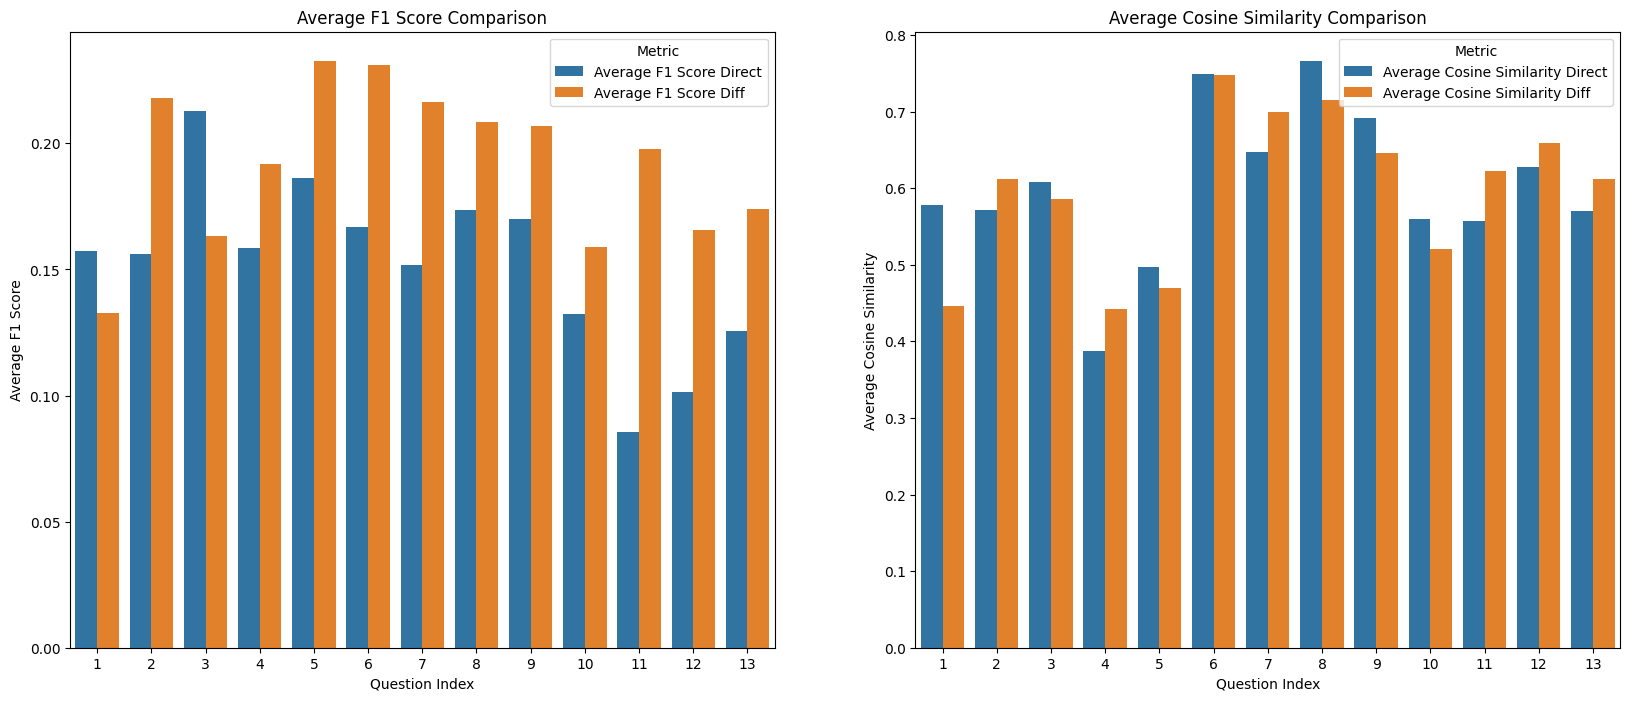

In [26]:
# compare the average F1 scores and cosine similarities between the direct grading and the grading with differences
# we will plot two bar plots, the x-axis is the question index, the y-axis is the average F1 score or cosine similarity. In each plot, we will compare the two grading methods on one metric.

# create a DataFrame for the comparison
f1_comparison = pd.DataFrame({
    'Question Index': list(range(1, len(oracle)+1)),
    'Average F1 Score Direct': avg_f1_direct,
    'Average F1 Score Diff': avg_f1_diff
})

cos_comparison = pd.DataFrame({
    'Question Index': list(range(1, len(oracle)+1)),
    'Average Cosine Similarity Direct': avg_cosine_direct,
    'Average Cosine Similarity Diff': avg_cosine_diff
})

# melt the DataFrame
f1_comparison_melted = f1_comparison.melt(id_vars='Question Index', var_name='Metric', value_name='Score')
cos_comparison_melted = cos_comparison.melt(id_vars='Question Index', var_name='Metric', value_name='Score')

# plot the two bar plots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.barplot(x='Question Index', y='Score', hue='Metric', data=f1_comparison_melted, ax=axes[0])
axes[0].set_title('Average F1 Score Comparison')
axes[0].set_ylabel('Average F1 Score')
axes[0].set_xlabel('Question Index')
sns.barplot(x='Question Index', y='Score', hue='Metric', data=cos_comparison_melted, ax=axes[1])
axes[1].set_title('Average Cosine Similarity Comparison')
axes[1].set_ylabel('Average Cosine Similarity')
axes[1].set_xlabel('Question Index')
plt.show()

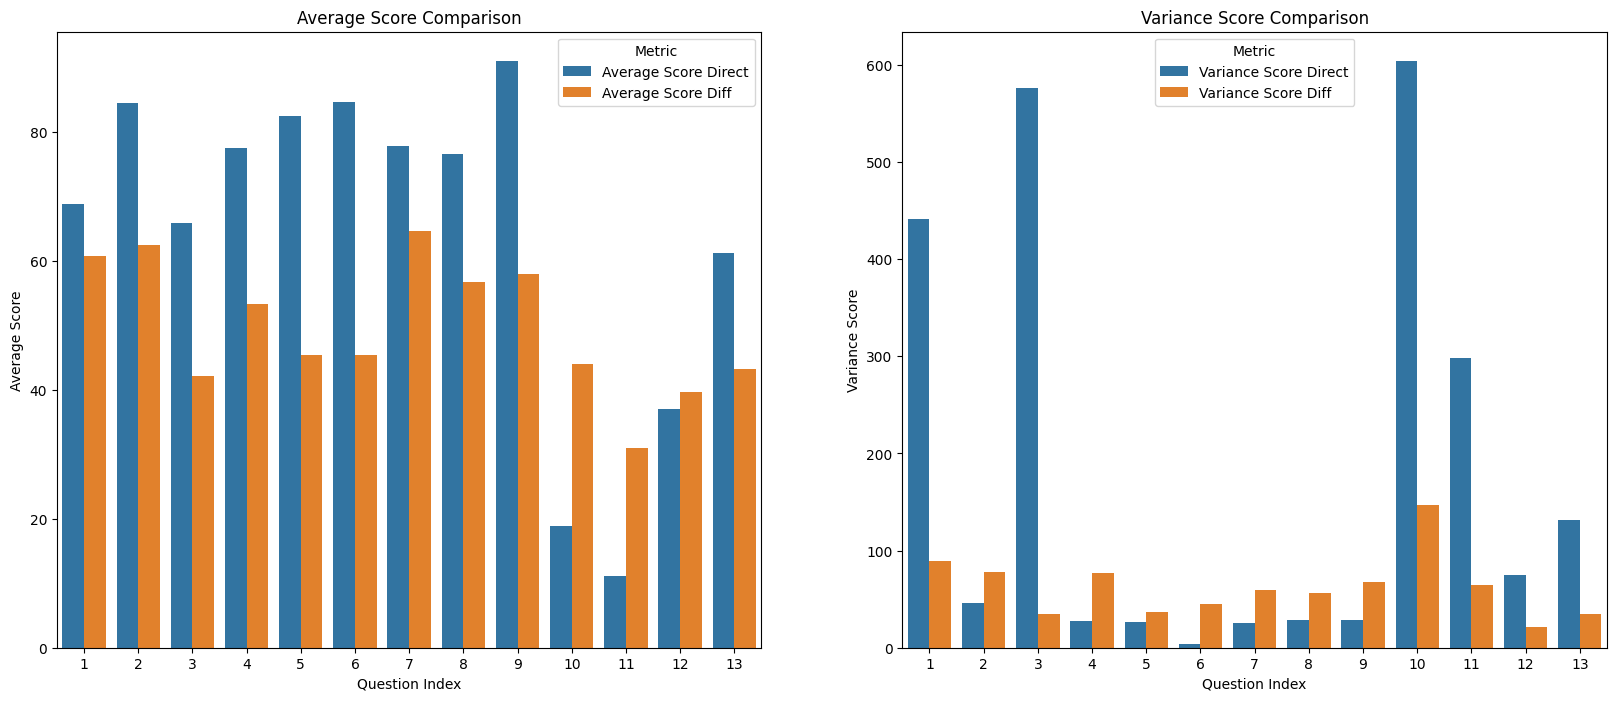

In [28]:
# compare the average scores between the two grading methods
avg_scores_direct = [np.mean(scores) for scores in scores_direct]
avg_scores_diff = [np.mean(scores) for scores in scores_diff]

# create a DataFrame for the comparison
score_comparison = pd.DataFrame({
    'Question Index': list(range(1, len(oracle)+1)),
    'Average Score Direct': avg_scores_direct,
    'Average Score Diff': avg_scores_diff
})

# melt the DataFrame
score_comparison_melted = score_comparison.melt(id_vars='Question Index', var_name='Metric', value_name='Score')

# calculate the variance of the scores for each question
var_scores_direct = [np.var(scores) for scores in scores_direct]
var_scores_diff = [np.var(scores) for scores in scores_diff]

# create a DataFrame for the comparison
var_score_comparison = pd.DataFrame({
    'Question Index': list(range(1, len(oracle)+1)),
    'Variance Score Direct': var_scores_direct,
    'Variance Score Diff': var_scores_diff
})

# melt the DataFrame
var_score_comparison_melted = var_score_comparison.melt(id_vars='Question Index', var_name='Metric', value_name='Variance')

# plot the two bar plots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
sns.barplot(x='Question Index', y='Score', hue='Metric', data=score_comparison_melted, ax=axes[0])
axes[0].set_title('Average Score Comparison')
axes[0].set_ylabel('Average Score')
axes[0].set_xlabel('Question Index')
sns.barplot(x='Question Index', y='Variance', hue='Metric', data=var_score_comparison_melted, ax=axes[1])
axes[1].set_title('Variance Score Comparison')
axes[1].set_ylabel('Variance Score')
axes[1].set_xlabel('Question Index')
plt.show()